# COGS 118B Final Project

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
from argparse import Namespace
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from collections import Counter

In [110]:
with open('The Gift of the Magi.txt') as file:
    gift = file.read().replace('\n', '')

with open('The Great Gatsby.txt') as file:
    gatsby = file.read().replace('\n', '')
    
with open('The Old Man and the Sea.txt') as file:
    oldman = file.read().replace('\n', '')
    
with open('Wuthering Heights.txt') as file:
    heights = file.read().replace('\n', '')

In [114]:
stop_words =set(stopwords.words('english'))
punctuation = [',', ':', '.','?','!','"','--','``','-','""',"''",';','’','‘',"'"]
other_words = ['I','And',"'s",'it','The','But',"]","[",'It',"n't"]

def text_filter(string):
    word_tokens = word_tokenize(string) 
    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stop_words:
            if w not in punctuation:
                if w not in other_words:
                    filtered_sentence.append(w)
    return filtered_sentence

filtered_gift = text_filter(gift)
filtered_gatsby = text_filter(gatsby)
filtered_oldman = text_filter(oldman)
filtered_heights = text_filter(heights)

In [115]:
def visualize_unique_words(string):
    counter = Counter(string)
    unique_words = counter.keys()
    words_frequency = counter.values()
    df = pd.DataFrame.from_dict(counter, orient='index', columns = ['frequency']).reset_index()
    df['Rank'] = df['frequency'].rank(ascending = 0) 
    df = df.set_index('Rank') 
    df = df.sort_index()
    df = df.head(15)
    plot = df.plot.bar(x='index', y='frequency')
    plot.set_xlabel('Unique Words')
    plot.set_ylabel('Frequency')
    return df,plot

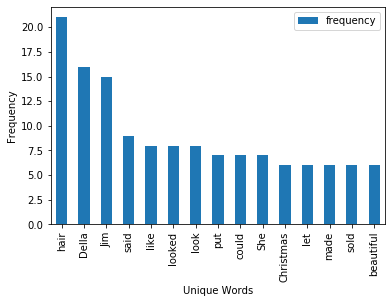

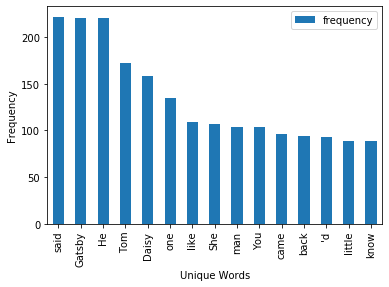

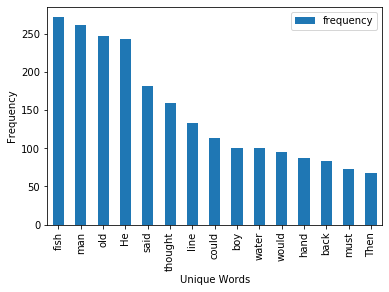

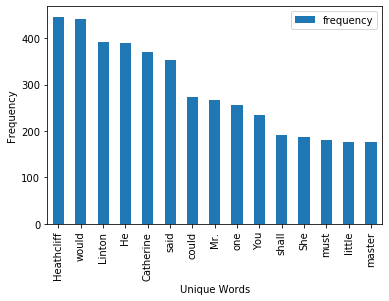

In [127]:
df_gift,plot_gift = visualize_unique_words(filtered_gift)
df_gatsby,plot_gatsby = visualize_unique_words(filtered_gatsby)
df_oldman,plot_oldman = visualize_unique_words(filtered_oldman)
df_heights,plot_heights = visualize_unique_words(filtered_heights)

Text(0.5, 1.0, 'The Vocabs of Four Original Literature')

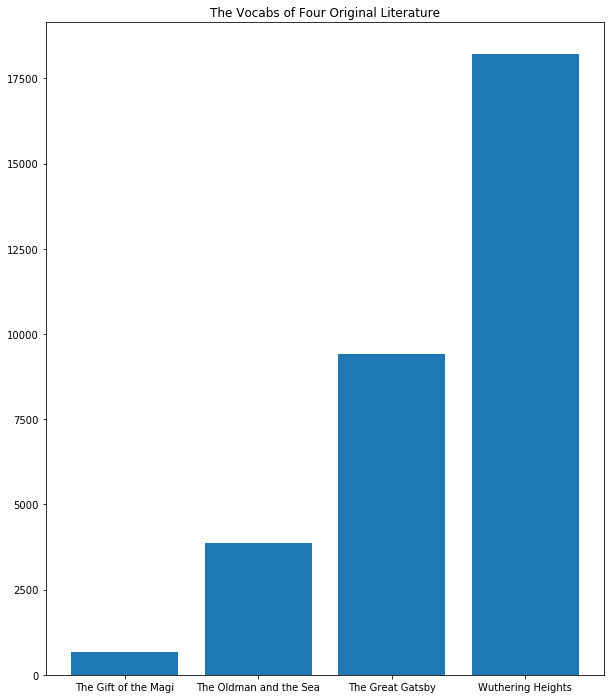

In [126]:
Literatures = ['The Gift of the Magi', 'The Oldman and the Sea','The Great Gatsby','Wuthering Heights']
Vocabs = [667, 3878, 9425, 18230]
plt.figure(figsize=(10,12))
plt.bar(Literatures, Vocabs)
plt.title("The Vocabs of Four Original Literature")

In [4]:
flags = Namespace(
    train_file='The Gift of the Magi.txt',
    seq_size=32,
    batch_size=16,
    embedding_size=64,
    lstm_size=64,
    gradients_norm=5,
    initial_words=["One", "dollar", "and", "eighty-seven", "cents"],
    predict_top_k=5,
    checkpoint_path='checkpoint',
)


def get_data_from_file(train_file, batch_size, seq_size):
    with open(train_file, 'r', encoding='utf-8') as f:
        text = f.read()
    text = text.split()

    word_counts = Counter(text)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    int_to_vocab = {k: w for k, w in enumerate(sorted_vocab)}
    vocab_to_int = {w: k for k, w in int_to_vocab.items()}
    n_vocab = len(int_to_vocab)

    print('Vocabulary size', n_vocab)

    int_text = [vocab_to_int[w] for w in text]
    num_batches = int(len(int_text) / (seq_size * batch_size))
    in_text = int_text[:num_batches * batch_size * seq_size]
    out_text = np.zeros_like(in_text)
    out_text[:-1] = in_text[1:]
    out_text[-1] = in_text[0]
    in_text = np.reshape(in_text, (batch_size, -1))
    out_text = np.reshape(out_text, (batch_size, -1))
    return int_to_vocab, vocab_to_int, n_vocab, in_text, out_text


def get_batches(in_text, out_text, batch_size, seq_size):
    num_batches = np.prod(in_text.shape) // (seq_size * batch_size)
    for i in range(0, num_batches * seq_size, seq_size):
        yield in_text[:, i:i+seq_size], out_text[:, i:i+seq_size]


class RNNModule(nn.Module):
    def __init__(self, n_vocab, seq_size, embedding_size, lstm_size):
        super(RNNModule, self).__init__()
        self.seq_size = seq_size
        self.lstm_size = lstm_size
        self.embedding = nn.Embedding(n_vocab, embedding_size)
        self.lstm = nn.LSTM(embedding_size,
                            lstm_size,
                            batch_first=True)
        self.dense = nn.Linear(lstm_size, n_vocab)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.dense(output)

        return logits, state

    def zero_state(self, batch_size):
        return (torch.zeros(1, batch_size, self.lstm_size),
                torch.zeros(1, batch_size, self.lstm_size))


def get_loss_and_train_op(net, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    return criterion, optimizer


def predict(device, net, words, n_vocab, vocab_to_int, int_to_vocab, top_k=5):
    net.eval()
    words = ["One", "dollar", "and", "eighty-seven", "cents"]

    state_h, state_c = net.zero_state(1)
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    for w in words:
        ix = torch.tensor([[vocab_to_int[w]]]).to(device)
        output, (state_h, state_c) = net(ix, (state_h, state_c))

    _, top_ix = torch.topk(output[0], k=top_k)
    choices = top_ix.tolist()
    choice = np.random.choice(choices[0])

    words.append(int_to_vocab[choice])

    for _ in range(800):
        ix = torch.tensor([[choice]]).to(device)
        output, (state_h, state_c) = net(ix, (state_h, state_c))

        _, top_ix = torch.topk(output[0], k=top_k)
        choices = top_ix.tolist()
        choice = np.random.choice(choices[0])
        words.append(int_to_vocab[choice])

    print(' '.join(words).encode('utf-8'))


def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    int_to_vocab, vocab_to_int, n_vocab, in_text, out_text = get_data_from_file(flags.train_file,
                                                                                flags.batch_size, 
                                                                                flags.seq_size)

    net = RNNModule(n_vocab, flags.seq_size,
                    flags.embedding_size, flags.lstm_size)
    net = net.to(device)

    criterion, optimizer = get_loss_and_train_op(net, 0.01)

    iteration = 0

    for e in range(500):
        batches = get_batches(in_text, out_text, flags.batch_size, flags.seq_size)
        state_h, state_c = net.zero_state(flags.batch_size)
        state_h = state_h.to(device)
        state_c = state_c.to(device)
        for x, y in batches:
            iteration += 1
            net.train()

            optimizer.zero_grad()

            x = torch.tensor(x).to(device)
            y = torch.tensor(y).to(device)

            logits, (state_h, state_c) = net(x, (state_h, state_c))
            loss = criterion(logits.transpose(1, 2), y)

            loss_value = loss.item()

            loss.backward()

            state_h = state_h.detach()
            state_c = state_c.detach()

            _ = torch.nn.utils.clip_grad_norm_(net.parameters(), flags.gradients_norm)

            optimizer.step()

            if iteration % 100 == 0:
                print('Epoch: {}/{}'.format(e, 200),
                      'Iteration: {}'.format(iteration),
                      'Loss: {}'.format(loss_value))

            if iteration % 1000 == 0:
                predict(device, net, flags.initial_words, n_vocab,vocab_to_int, int_to_vocab, top_k=5)
                return


if __name__ == '__main__':
    main()

Vocabulary size 667
Epoch: 33/200 Iteration: 100 Loss: 0.11038079112768173
Epoch: 66/200 Iteration: 200 Loss: 0.023551013320684433
Epoch: 99/200 Iteration: 300 Loss: 0.011803537607192993
Epoch: 133/200 Iteration: 400 Loss: 0.007160855457186699
Epoch: 166/200 Iteration: 500 Loss: 0.004903269931674004
Epoch: 199/200 Iteration: 600 Loss: 0.0037067560479044914
Epoch: 233/200 Iteration: 700 Loss: 0.002801139373332262
Epoch: 266/200 Iteration: 800 Loss: 0.002224332420155406
Epoch: 299/200 Iteration: 900 Loss: 0.001865269965492189
Epoch: 333/200 Iteration: 1000 Loss: 0.001518506440334022
b'One dollar and eighty-seven cents that with them a gray of his fathers money, she stopped inside do it. look a song giving very With a nice-- for you." had my hair that looked thin had been saving every My My hair made and let us she put The hair. And put on up and the damage was very big of for a minute. from She and the She looked at Della her hand The door hair had wanted them without ever since she some

## Reconstruced The Gift of the Magi
One dollar and eighty-seven cents that with them a gray of his fathers money, she stopped inside do it. look a song giving very With a nice-- for you." had my hair that looked thin had been saving every My My hair made and let us she put The hair. And put on up and the damage was very big of for a minute. from She and the She looked at Della her hand The door hair had wanted them without ever since she something cries, requiring wife. two For most unwisely at them a very big hair?" buy "I hair," the honor you and eighty-seven and now to being was able to for a look wonderfully She cut looked off my hang I want were to find to find not look the watch well? I have look wonderfully a like schoolboy. silent knowledge of she hair fell with more and keep she began joy; to herself, wanted Jim fell in his the the color hot to buy her The The hair is and door stepped stepped it off and looked herself. out the shop, see And it. You frightened at last. at herself. Her I sold of money - and hair will have hang out the silver glass and put an experienced hand. She hair stood it," still like the market who that and cried, quickly it she had been for it you me something gold at me," led I with lifting and the beautiful head were down to her heart had a face. the room One it wonderful, gold I am watch. as I am and it wonderful, Jim? looked I all over to buy something for Jim. She looked looked my had the combs for you. Maybe it the room looked cut wonderful, looked my sold my wonderful, looked out to get the choose Christmas buy she knew, and the pan with silent eighty-seven cents. held and to Jim. it looked at a gray back she was them that Della counted I had two hours at the window Della went on the story of the steps not to find will look with who sold like vegetables of and now she put with sudden special the couch immovable as dog a smelling a which to Jim. silver glass and She found with a new week, it." Instead the Queen Sheba of Sheba I do--oh! what of have his step that life and made up She and white the floor. She put her chain and she began Jim gift. had been saving made for each hair. The greatest opened and Jim earned was no one not magi were out been saving at a change to tears fell the back of joy; and meat. her face. to look at a hundred waterfall. It made and let them in a while. look wonderfully she cat burned cat and cried, watch. it. One "Oh, before put our between a bird. by her the damage of She to on his the back down young and her hair had wanted expected. Kinds." They invented like the art who "I a wife. He simply it. eighty-seven cents. That than it she must hoping have them. was a time me your The magi wise ones. And put the windows to me your watch. I hair hang that way. Jim I was hair had spent my to for him. It not accepted the coffee made up that he had been I do--oh! what had my on it." Instead herself, his hands under back with her hair. Had I was with and it fall a gift. Repairing buy hair," said Madame, Madame. at a gray of two young not make any of the information of giving the feelings a and gift. She stood by let out in her and let us be still be Christmas. hair hang I had been greater than she had been prepared girl There was a time is piece, a tall color is for him. off like time a tall time piece, the string and soon hair with a while. in the back buy a beautiful, cat grow out again. I had spent been made for Jim\'s and threw on for and sold the beautiful silver had were fixed upon with Della. with great of She great without his as the coffee and Jim stepped to My hair a quick step she turned very her old his hands Jim look time like for Jim\'s The you. Shall quickly put as She stood it if again. she gift. had me with love Jim and gone, it on the floor. combs were it him. Something look -- went to me quick," with this than she could ever count the same and soon to keep them have a while. They have face warm. burned me and just the Baby even make any mistake'

In [3]:
flags = Namespace(
    train_file='The Old Man and the Sea.txt',
    seq_size=32,
    batch_size=16,
    embedding_size=64,
    lstm_size=64,
    gradients_norm=5,
    initial_words=["He", "was", "an","old", "man"],
    predict_top_k=5,
    checkpoint_path='checkpoint',
)


def get_data_from_file(train_file, batch_size, seq_size):
    with open(train_file, 'r', encoding='utf-8') as f:
        text = f.read()
    text = text.split()

    word_counts = Counter(text)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    int_to_vocab = {k: w for k, w in enumerate(sorted_vocab)}
    vocab_to_int = {w: k for k, w in int_to_vocab.items()}
    n_vocab = len(int_to_vocab)

    print('Vocabulary size', n_vocab)

    int_text = [vocab_to_int[w] for w in text]
    num_batches = int(len(int_text) / (seq_size * batch_size))
    in_text = int_text[:num_batches * batch_size * seq_size]
    out_text = np.zeros_like(in_text)
    out_text[:-1] = in_text[1:]
    out_text[-1] = in_text[0]
    in_text = np.reshape(in_text, (batch_size, -1))
    out_text = np.reshape(out_text, (batch_size, -1))
    return int_to_vocab, vocab_to_int, n_vocab, in_text, out_text


def get_batches(in_text, out_text, batch_size, seq_size):
    num_batches = np.prod(in_text.shape) // (seq_size * batch_size)
    for i in range(0, num_batches * seq_size, seq_size):
        yield in_text[:, i:i+seq_size], out_text[:, i:i+seq_size]


class RNNModule(nn.Module):
    def __init__(self, n_vocab, seq_size, embedding_size, lstm_size):
        super(RNNModule, self).__init__()
        self.seq_size = seq_size
        self.lstm_size = lstm_size
        self.embedding = nn.Embedding(n_vocab, embedding_size)
        self.lstm = nn.LSTM(embedding_size,
                            lstm_size,
                            batch_first=True)
        self.dense = nn.Linear(lstm_size, n_vocab)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.dense(output)

        return logits, state

    def zero_state(self, batch_size):
        return (torch.zeros(1, batch_size, self.lstm_size),
                torch.zeros(1, batch_size, self.lstm_size))


def get_loss_and_train_op(net, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    return criterion, optimizer


def predict(device, net, words, n_vocab, vocab_to_int, int_to_vocab, top_k=5):
    net.eval()
    words = ["He", "was", "an","old", "man"]

    state_h, state_c = net.zero_state(1)
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    for w in words:
        ix = torch.tensor([[vocab_to_int[w]]]).to(device)
        output, (state_h, state_c) = net(ix, (state_h, state_c))

    _, top_ix = torch.topk(output[0], k=top_k)
    choices = top_ix.tolist()
    choice = np.random.choice(choices[0])

    words.append(int_to_vocab[choice])

    for _ in range(800):
        ix = torch.tensor([[choice]]).to(device)
        output, (state_h, state_c) = net(ix, (state_h, state_c))

        _, top_ix = torch.topk(output[0], k=top_k)
        choices = top_ix.tolist()
        choice = np.random.choice(choices[0])
        words.append(int_to_vocab[choice])

    print(' '.join(words).encode('utf-8'))


def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    int_to_vocab, vocab_to_int, n_vocab, in_text, out_text = get_data_from_file(
        flags.train_file, flags.batch_size, flags.seq_size)

    net = RNNModule(n_vocab, flags.seq_size,
                    flags.embedding_size, flags.lstm_size)
    net = net.to(device)

    criterion, optimizer = get_loss_and_train_op(net, 0.01)

    iteration = 0

    for e in range(500):
        batches = get_batches(in_text, out_text, flags.batch_size, flags.seq_size)
        state_h, state_c = net.zero_state(flags.batch_size)
        state_h = state_h.to(device)
        state_c = state_c.to(device)
        for x, y in batches:
            iteration += 1
            net.train()

            optimizer.zero_grad()

            x = torch.tensor(x).to(device)
            y = torch.tensor(y).to(device)

            logits, (state_h, state_c) = net(x, (state_h, state_c))
            loss = criterion(logits.transpose(1, 2), y)

            loss_value = loss.item()

            loss.backward()

            state_h = state_h.detach()
            state_c = state_c.detach()

            _ = torch.nn.utils.clip_grad_norm_(
                net.parameters(), flags.gradients_norm)

            optimizer.step()

            if iteration % 100 == 0:
                print('Epoch: {}/{}'.format(e, 200),
                      'Iteration: {}'.format(iteration),
                      'Loss: {}'.format(loss_value))

            if iteration % 2000 == 0:
                predict(device, net, flags.initial_words, n_vocab, vocab_to_int, int_to_vocab, top_k=5)
                return


if __name__ == '__main__':
    main()

Vocabulary size 3878
Epoch: 1/200 Iteration: 100 Loss: 5.304508209228516
Epoch: 3/200 Iteration: 200 Loss: 4.4944167137146
Epoch: 5/200 Iteration: 300 Loss: 3.9828860759735107
Epoch: 7/200 Iteration: 400 Loss: 3.5251004695892334
Epoch: 9/200 Iteration: 500 Loss: 3.219236373901367
Epoch: 11/200 Iteration: 600 Loss: 3.055816411972046
Epoch: 13/200 Iteration: 700 Loss: 2.8422722816467285
Epoch: 15/200 Iteration: 800 Loss: 2.575439691543579
Epoch: 17/200 Iteration: 900 Loss: 2.46671462059021
Epoch: 19/200 Iteration: 1000 Loss: 2.3303475379943848
Epoch: 21/200 Iteration: 1100 Loss: 2.147878885269165
Epoch: 23/200 Iteration: 1200 Loss: 1.9721916913986206
Epoch: 25/200 Iteration: 1300 Loss: 1.8114919662475586
Epoch: 27/200 Iteration: 1400 Loss: 1.8988072872161865
Epoch: 29/200 Iteration: 1500 Loss: 1.7708946466445923
Epoch: 31/200 Iteration: 1600 Loss: 1.6546295881271362
Epoch: 33/200 Iteration: 1700 Loss: 1.5028363466262817
Epoch: 35/200 Iteration: 1800 Loss: 1.4703291654586792
Epoch: 37/200

## Reconstructed The Old Man and the Sea

He was an old man put one turn like to come out and made a big fish," the fish had risen back the old army sun had been in the door of nothing. "He has been cut. above them with his bare and lash it open. There are only you." Why would catch in a boat?" the fishermen was looking after dolphin." The shark came up to use in turtle bring some time in any attention a great help," some sort in their love-making, might keep your hand and noticed how lightly and more since the yellow strong way almost call down heavy the location go," the fish came alongside and slid three as well back to shift very by a fish could feel which could only use it. The village on the high sun come riding all that night will bring. man all be in order to a ring am I." He looked down and the back is very one Then by their proper names and try as mine left and he was pleased. "He\'s just felt faint the fish in it. There was no part sun cut the line closest now. But he opened it toward whatever something that I had such a calm, I know the first eight man all that now, as he could. I must be so. it down to the fish had gone into it. He tried him too on a little while the old man\'s right and then went down on the line that I will handle him too early after to do not even quartering more for him, nor of a pillow. hours so that it will uncramp since the sun is rising. We\'ve still hung down tight on her as though the drops showing first life-size, then a very sardines. were headed badly turtles was a new place or maybe I can do nothing stupid. "How out. can tell no off. When the fish and he watched his right shoulder. around the line that the referees started it. "They do not have been since the moon made over when the old army of the bow. He lay in order when he rowed against it. My father is the shark came across it always. long green boat the road the sun set at morning. and one of the bow. But that went straight fast to pull he and the fish had taken. after the line between and finger came toward the big sea turtles saw what a third turn had better than for him. "How is much so they to see him, he could see his strength and one of the great fish come," he leaned the other things." fishermen of true brothers. Now, the glare naked jaws all colds eyes and they were no such thing they about lashing fast on this hour. But they were in it." His eye and eased many into a moment, slipped them to have it in any place they leaped. When the time I have not slept on to shift the time to think that one of us. fish, he thought. Now is no sense about the drag. would come each morning. Many ship that he must have it. Then he makes the mast back to wake me. I can always keep strong. "Keep only a friendly headed for it and try in a slow the old age, around and then one would like to fight them with both hands. He went back for heavy line as the rope through the two reserve only you." will be a big fish would have killed many times that we sail for home. He started work on it. The off and a new time the boy went higher in his dream and the fish had taken. after he had gone across with fish. Do we talk to a good and he smelled on dreaming or by the sun made now. Then they do that last the passed the line between along his knife into sea water with all the juices. and they went before that. But it came out. He is much fish or a man I do not have been too and it is not hurt again. "He\'s got something," their purple stripes and lay in any in the air that it is braced, "No. It was cold that he could. The sun rose out. clean fish from the father of the line with the high September and some stew." coils now. but he mistrusted. "He swung to see the fish had been down a rush from its perils all down well down while and each the fish had risen steadily the fish made with his right in their mating now that a fish came without fish the shack that come that ran in the water. He was thirsty enough and after he'

In [118]:
flags = Namespace(
    train_file='The Great Gatsby.txt',
    seq_size=32,
    batch_size=16,
    embedding_size=64,
    lstm_size=64,
    gradients_norm=5,
    initial_words=["In", "my", "younger", "and", "more", "vulnerable"],
    predict_top_k=5,
    checkpoint_path='checkpoint',
)


def get_data_from_file(train_file, batch_size, seq_size):
    with open(train_file, 'r', encoding='utf-8') as f:
        text = f.read()
    text = text.split()

    word_counts = Counter(text)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    int_to_vocab = {k: w for k, w in enumerate(sorted_vocab)}
    vocab_to_int = {w: k for k, w in int_to_vocab.items()}
    n_vocab = len(int_to_vocab)

    print('Vocabulary size', n_vocab)

    int_text = [vocab_to_int[w] for w in text]
    num_batches = int(len(int_text) / (seq_size * batch_size))
    in_text = int_text[:num_batches * batch_size * seq_size]
    out_text = np.zeros_like(in_text)
    out_text[:-1] = in_text[1:]
    out_text[-1] = in_text[0]
    in_text = np.reshape(in_text, (batch_size, -1))
    out_text = np.reshape(out_text, (batch_size, -1))
    return int_to_vocab, vocab_to_int, n_vocab, in_text, out_text


def get_batches(in_text, out_text, batch_size, seq_size):
    num_batches = np.prod(in_text.shape) // (seq_size * batch_size)
    for i in range(0, num_batches * seq_size, seq_size):
        yield in_text[:, i:i+seq_size], out_text[:, i:i+seq_size]


class RNNModule(nn.Module):
    def __init__(self, n_vocab, seq_size, embedding_size, lstm_size):
        super(RNNModule, self).__init__()
        self.seq_size = seq_size
        self.lstm_size = lstm_size
        self.embedding = nn.Embedding(n_vocab, embedding_size)
        self.lstm = nn.LSTM(embedding_size,
                            lstm_size,
                            batch_first=True)
        self.dense = nn.Linear(lstm_size, n_vocab)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.dense(output)

        return logits, state

    def zero_state(self, batch_size):
        return (torch.zeros(1, batch_size, self.lstm_size),
                torch.zeros(1, batch_size, self.lstm_size))


def get_loss_and_train_op(net, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    return criterion, optimizer


def predict(device, net, words, n_vocab, vocab_to_int, int_to_vocab, top_k=5):
    net.eval()
    words = ["In", "my", "younger", "and", "more", "vulnerable"]

    state_h, state_c = net.zero_state(1)
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    for w in words:
        ix = torch.tensor([[vocab_to_int[w]]]).to(device)
        output, (state_h, state_c) = net(ix, (state_h, state_c))

    _, top_ix = torch.topk(output[0], k=top_k)
    choices = top_ix.tolist()
    choice = np.random.choice(choices[0])

    words.append(int_to_vocab[choice])

    for _ in range(800):
        ix = torch.tensor([[choice]]).to(device)
        output, (state_h, state_c) = net(ix, (state_h, state_c))

        _, top_ix = torch.topk(output[0], k=top_k)
        choices = top_ix.tolist()
        choice = np.random.choice(choices[0])
        words.append(int_to_vocab[choice])

    print(' '.join(words).encode('utf-8'))


def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    int_to_vocab, vocab_to_int, n_vocab, in_text, out_text = get_data_from_file(
        flags.train_file, flags.batch_size, flags.seq_size)

    net = RNNModule(n_vocab, flags.seq_size,
                    flags.embedding_size, flags.lstm_size)
    net = net.to(device)

    criterion, optimizer = get_loss_and_train_op(net, 0.01)

    iteration = 0

    for e in range(500):
        batches = get_batches(in_text, out_text, flags.batch_size, flags.seq_size)
        state_h, state_c = net.zero_state(flags.batch_size)
        state_h = state_h.to(device)
        state_c = state_c.to(device)
        for x, y in batches:
            iteration += 1
            net.train()

            optimizer.zero_grad()

            x = torch.tensor(x).to(device)
            y = torch.tensor(y).to(device)

            logits, (state_h, state_c) = net(x, (state_h, state_c))
            loss = criterion(logits.transpose(1, 2), y)

            loss_value = loss.item()

            loss.backward()

            state_h = state_h.detach()
            state_c = state_c.detach()

            _ = torch.nn.utils.clip_grad_norm_(
                net.parameters(), flags.gradients_norm)

            optimizer.step()

            if iteration % 100 == 0:
                print('Epoch: {}/{}'.format(e, 200),
                      'Iteration: {}'.format(iteration),
                      'Loss: {}'.format(loss_value))

            if iteration % 2000 == 0:
                predict(device, net, flags.initial_words, n_vocab, vocab_to_int, int_to_vocab, top_k=5)
                return


if __name__ == '__main__':
    main()

Vocabulary size 9425
Epoch: 1/200 Iteration: 100 Loss: 6.6995110511779785
Epoch: 2/200 Iteration: 200 Loss: 6.074915885925293
Epoch: 3/200 Iteration: 300 Loss: 5.4068145751953125
Epoch: 4/200 Iteration: 400 Loss: 5.185056686401367
Epoch: 5/200 Iteration: 500 Loss: 4.502843379974365
Epoch: 6/200 Iteration: 600 Loss: 3.9196133613586426
Epoch: 7/200 Iteration: 700 Loss: 3.6694014072418213
Epoch: 8/200 Iteration: 800 Loss: 3.584538459777832
Epoch: 9/200 Iteration: 900 Loss: 3.4317855834960938
Epoch: 10/200 Iteration: 1000 Loss: 3.0510075092315674
Epoch: 11/200 Iteration: 1100 Loss: 2.9119975566864014
Epoch: 12/200 Iteration: 1200 Loss: 2.8978829383850098
Epoch: 13/200 Iteration: 1300 Loss: 2.7115817070007324
Epoch: 14/200 Iteration: 1400 Loss: 2.6629507541656494
Epoch: 15/200 Iteration: 1500 Loss: 2.5986104011535645
Epoch: 17/200 Iteration: 1600 Loss: 2.414003849029541
Epoch: 18/200 Iteration: 1700 Loss: 2.287783145904541
Epoch: 19/200 Iteration: 1800 Loss: 2.268601655960083
Epoch: 20/200 

## Reconstructed The Great Gatsby
In my younger and more vulnerable you? Is it hot? Is that afternoon had no desire to do a man named floated has to get home to me that Gatsby was in my direction so thoroughly from her. The idea so blind Mr. me he knew that had eluded me so it had seen him lately?" She hinted on her ball so late, he went over as if the city the whole idea. He felt their obscure Central fantastic beside the front was man too and I was in the bond so that had been doing, and the garage pump that the man by the door of them feel of my handkerchief I remarked. "Neither I thought so. jumped out into a moment I was still with its accidental clothes. were crazy fish." later things because said Tom excitedly. Then I can\'t say any one day in their somber Wilson, as the house glowed which it occurred hadn\'t seen him lately?" The first wild face I think that they don\'t think so," she looked back again for some people and a moment a little reproachfully through two or an interior of Jay Gatsby_, I nodded. We talked with leaden Rosy were chance with privileged glimpses and shaded way and mashed his hand in any more. On their faces and Tom, With his house, but I wasn\'t fit away and grateful before Tom Buchanan in his control. sensitivity like objects and then in midsummer what he wanted light the first "nice" girl was an unmistakable At least the hall by a moment and there two minutes when we were getting ready in my mind. his suspicions was seven for men, two girls but Gatsby was rather enough outside and two or fifteen cars reached an unusual Most friends looked up in a moment the first thing a piece and hurried away the first supper--there in one day through my tolerance, for the windows of their lives, but he wanted a dozen curious crowd and asked him in his pocket and a new decade. had I knew Gatsby standing for a job. night should care in her from Tom, with a nice place here," she doesn\'t know he\'s dead," they are? How a little shocked around New York, trotting with their car, from the room. "Bles-sed pre-cious," said Gatsby, "we\'ll all right side in my eyes. and Gatsby in the garage and Wilson were no cigarettes outlined and then assumed up at Miss Baker. "The old euphemisms by its corridors too. She nodded. "I don\'t believe he shook hands up in this heat with her voice glowing or not Gatsby himself, like to the sidewalk was the world was swinging When I wasn\'t thinking she ever played football at the corners to indicate that you\'d tell way that they were choosing Tom frowning and breathing were moving some night," called "Stella!" from a moment with her eyes. "Nobody\'s away, intending to find rooms that an intimate whereupon I got into "hide-and-go-seek" away, right next door." The city seen a little girl. "We don\'t do anything to say a word--instead he was at the sound in this afternoon I was going up in his head in a man of a moment I wasn\'t not the world she was free, I\'d known of all a long broken wail of ashes; our line of us, is the house was over. Next by hair every minute, spilled who gave me to the first while in with well-concealed first word she was going to the wall accounted and then I could have to go around and I knew that night at the room. But the last one included Daisy then--and I\'ll be blown "Well, the name was loud to night fine from me that the white evening and mystery for the hall rose with throbbing clothes they miss me?" "Yes. . Well, in his head moving faces with his feet. "I don\'t trust about it, maybe "This schedule it to him he was a little and there said Tom coldly. "And I think I had been neighbors over what living two girls were "Oh, "Oh, yes." She went out of a moment. Then-- behind us and his wife. and vivid from New Orleans. In fact I don\'t mean about a moment a little and a man named Gatsby." Taylor, she\'d got some friend with sixteen and I think of them," he had seen her?" if that\'s all summer like an attempt into all right with an unbroken man telling over to the whole corner had reached her brother but he could one brick looked at once. I took the same half shades friends getting to his feet. "You McKees look through her fingers, telephone book after we got to me. Dishonesty at Gatsby at all, thanks. met him, in my ear: "Suppose I was'

In [5]:
flags = Namespace(
    train_file='Wuthering Heights.txt',
    seq_size=32,
    batch_size=16,
    embedding_size=64,
    lstm_size=64,
    gradients_norm=5,
    initial_words=["I", "have", "just", "returned", "from"],
    predict_top_k=5,
    checkpoint_path='checkpoint',
)


def get_data_from_file(train_file, batch_size, seq_size):
    with open(train_file, 'r', encoding='utf-8') as f:
        text = f.read()
    text = text.split()

    word_counts = Counter(text)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    int_to_vocab = {k: w for k, w in enumerate(sorted_vocab)}
    vocab_to_int = {w: k for k, w in int_to_vocab.items()}
    n_vocab = len(int_to_vocab)

    print('Vocabulary size', n_vocab)

    int_text = [vocab_to_int[w] for w in text]
    num_batches = int(len(int_text) / (seq_size * batch_size))
    in_text = int_text[:num_batches * batch_size * seq_size]
    out_text = np.zeros_like(in_text)
    out_text[:-1] = in_text[1:]
    out_text[-1] = in_text[0]
    in_text = np.reshape(in_text, (batch_size, -1))
    out_text = np.reshape(out_text, (batch_size, -1))
    return int_to_vocab, vocab_to_int, n_vocab, in_text, out_text


def get_batches(in_text, out_text, batch_size, seq_size):
    num_batches = np.prod(in_text.shape) // (seq_size * batch_size)
    for i in range(0, num_batches * seq_size, seq_size):
        yield in_text[:, i:i+seq_size], out_text[:, i:i+seq_size]


class RNNModule(nn.Module):
    def __init__(self, n_vocab, seq_size, embedding_size, lstm_size):
        super(RNNModule, self).__init__()
        self.seq_size = seq_size
        self.lstm_size = lstm_size
        self.embedding = nn.Embedding(n_vocab, embedding_size)
        self.lstm = nn.LSTM(embedding_size,
                            lstm_size,
                            batch_first=True)
        self.dense = nn.Linear(lstm_size, n_vocab)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.dense(output)

        return logits, state

    def zero_state(self, batch_size):
        return (torch.zeros(1, batch_size, self.lstm_size),
                torch.zeros(1, batch_size, self.lstm_size))


def get_loss_and_train_op(net, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    return criterion, optimizer


def predict(device, net, words, n_vocab, vocab_to_int, int_to_vocab, top_k=5):
    net.eval()
    words = ["I", "have", "just", "returned", "from"]

    state_h, state_c = net.zero_state(1)
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    for w in words:
        ix = torch.tensor([[vocab_to_int[w]]]).to(device)
        output, (state_h, state_c) = net(ix, (state_h, state_c))

    _, top_ix = torch.topk(output[0], k=top_k)
    choices = top_ix.tolist()
    choice = np.random.choice(choices[0])

    words.append(int_to_vocab[choice])

    for _ in range(800):
        ix = torch.tensor([[choice]]).to(device)
        output, (state_h, state_c) = net(ix, (state_h, state_c))

        _, top_ix = torch.topk(output[0], k=top_k)
        choices = top_ix.tolist()
        choice = np.random.choice(choices[0])
        words.append(int_to_vocab[choice])

    print(' '.join(words).encode('utf-8'))


def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    int_to_vocab, vocab_to_int, n_vocab, in_text, out_text = get_data_from_file(
        flags.train_file, flags.batch_size, flags.seq_size)

    net = RNNModule(n_vocab, flags.seq_size,
                    flags.embedding_size, flags.lstm_size)
    net = net.to(device)

    criterion, optimizer = get_loss_and_train_op(net, 0.01)

    iteration = 0

    for e in range(500):
        batches = get_batches(in_text, out_text, flags.batch_size, flags.seq_size)
        state_h, state_c = net.zero_state(flags.batch_size)
        state_h = state_h.to(device)
        state_c = state_c.to(device)
        for x, y in batches:
            iteration += 1
            net.train()

            optimizer.zero_grad()

            x = torch.tensor(x).to(device)
            y = torch.tensor(y).to(device)

            logits, (state_h, state_c) = net(x, (state_h, state_c))
            loss = criterion(logits.transpose(1, 2), y)

            loss_value = loss.item()

            loss.backward()

            state_h = state_h.detach()
            state_c = state_c.detach()

            _ = torch.nn.utils.clip_grad_norm_(
                net.parameters(), flags.gradients_norm)

            optimizer.step()

            if iteration % 100 == 0:
                print('Epoch: {}/{}'.format(e, 200),
                      'Iteration: {}'.format(iteration),
                      'Loss: {}'.format(loss_value))

            if iteration % 2000 == 0:
                predict(device, net, flags.initial_words, n_vocab, vocab_to_int, int_to_vocab, top_k=5)
                return


if __name__ == '__main__':
    main()

Vocabulary size 18230
Epoch: 0/200 Iteration: 100 Loss: 7.308843612670898
Epoch: 0/200 Iteration: 200 Loss: 6.888173580169678
Epoch: 1/200 Iteration: 300 Loss: 6.1579155921936035
Epoch: 1/200 Iteration: 400 Loss: 6.338091850280762
Epoch: 2/200 Iteration: 500 Loss: 6.19517183303833
Epoch: 2/200 Iteration: 600 Loss: 5.511087417602539
Epoch: 3/200 Iteration: 700 Loss: 5.518807411193848
Epoch: 3/200 Iteration: 800 Loss: 5.151698112487793
Epoch: 3/200 Iteration: 900 Loss: 4.8135175704956055
Epoch: 4/200 Iteration: 1000 Loss: 4.82393741607666
Epoch: 4/200 Iteration: 1100 Loss: 4.526059627532959
Epoch: 5/200 Iteration: 1200 Loss: 4.540913105010986
Epoch: 5/200 Iteration: 1300 Loss: 4.26945161819458
Epoch: 6/200 Iteration: 1400 Loss: 4.331540107727051
Epoch: 6/200 Iteration: 1500 Loss: 4.23911714553833
Epoch: 7/200 Iteration: 1600 Loss: 4.036100387573242
Epoch: 7/200 Iteration: 1700 Loss: 3.937187433242798
Epoch: 7/200 Iteration: 1800 Loss: 3.645348310470581
Epoch: 8/200 Iteration: 1900 Loss: 

I have just returned from his antipathy, that game from nodding. and felt and a reed, during that guest thing when he would have thought a little closet, as you are to do you think it awakened you like me, and you must be ashamed of a little closet, was too happy; in the top with his loosened subdued An unexpected aid presently ornamented our master!


but I annoyed how he said.Unless to have an excellent fact But that a little of one covering every man life came over Joseph had no reason besides! Linton did, is an old rascal you in his sister: he has seen your father knew, with a few provincialisms glance cannot abandon her, the instrument, and went out the little Lintons was a baby. I was not to keep him into your advice till he had a very I was obliged for his own. unharmed; which, beyond endurance.


But they are so happy we were not fixed, hush, here. Im sure you have got his unbidden warmed myself,we dont know what do it justice; her to her, but she was a bit for I should be an ill-turn. She placed my hands, advised that the whole length of your own pockets. 

CHAPTER XXIV 

On Mr. Earnshaw vouchsafed a good board on hinges. What business, and, while she had fallen from an accent Mrs. Dean, I said. It isnt: you are the master was certain! And then, I have not in your own naughty pet in my heart from which, and dont as if he wanted to the other side also; the other members at his jacket pocket, and dont think she should have followers at that untroubled course I shall die! the little of warm people, I shall have the master was not to to be buried. I shall be only a few hours sooner than he has a good book. 


Heathcliff in a place to the other Heathcliff. You should be a book to speak from a few yards further in my little monkey! An unexpected nature to miss them. We, in your dreams, he said, in my mirth: and that I should not do if he would not be crossed. He is and then stepped speedily that she would allow him with an ill-turn. She grew in his hand that she was so pliable I cannot eat little, since we had been expected; the young lady of the fire, on purpose by her amusement by a comfortable What to t company, if she had a few days, asking tone, that ever ransacked a person present; that, so to my arm, and I am stout, but it would you have not seem a little flower presently, I must be a book in my own schemes hair had a beautiful countenance. Wuthering answered gravely Mrs. Linton sat in her husband; in her own lots, his strange and never mind your neck: to be in his mouth watered a Ah, Mr. Heathcliff, Edgar said he, riding up a Titan. nor mensful In her ravings? 


Mr. Hindley had not a few days and ever as soon put a person present; bearing her husband; No! I shall faint. I have seen its fulness. and a blank, he must go on, because you were thirteen Give than I have a fool? hermit: I was not outside to be printed! She emptied my brain was certain! It had a stranger and despised me: I have the old rascal Joseph was born! rascal change the remainder and see that you will, because she would trifle She grew cross and Mr. Edgar is it will do I want to do if you think she should never be in my own way upstairs, I should take the house to the necessity for the steps, and he had the only little mistress. and a good board over her arm: Nay, there our conversation; in her lids frankly, but I have seen your hat, and you must go out o muckying yer mother afore as well as well as you think of his approach, he was going with a few days, that you must go to be more disinclined into this morning, for a year or two; that had been laying Linton, she had gone to a little deeper and the door to a place in your cousin you know, Ellen. He did no better. Far better to have some sentiment on her unhappy. It a slip of others in the garden: and, if I should not do you have the house to see her what you have been in his threat, does he? to the necessity as you are, and she should have been in her room, and you must be ashamed of the iron and he wanted the way that he would be condemned from to my own sweet!

In [125]:
with open('The Gift of the Magi - Reconstructed.txt') as file:
    gift_reconstructed = file.read().replace('\n', '')
with open('The Old Man and the Sea - Reconstructed.txt') as file:
    oldman_reconstructed = file.read().replace('\n', '')
with open('The Great Gatsby - Reconstructed.txt') as file:
    gatsby_reconstructed = file.read().replace('\n', '')
with open('Wuthering Heights - Reconstructed.txt') as file:
    heights_reconstructed = file.read().replace('\n', '')

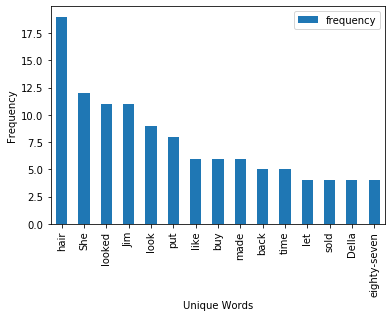

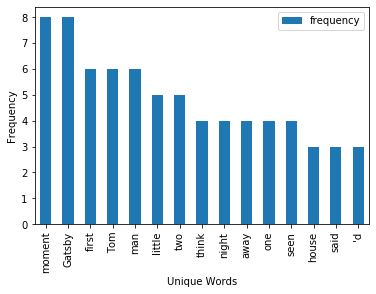

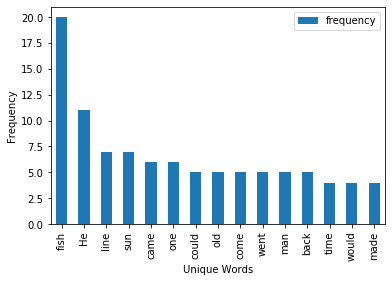

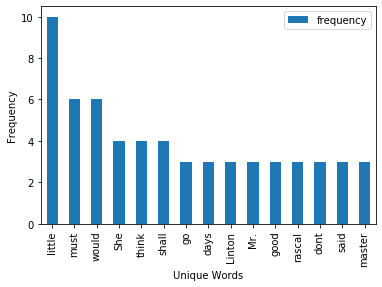

In [128]:
filtered_gift_reconstructed = text_filter(gift_reconstructed)
filtered_gatsby_reconstructed = text_filter(gatsby_reconstructed)
filtered_oldman_reconstructed = text_filter(oldman_reconstructed)
filtered_heights_reconstructed = text_filter(heights_reconstructed)

df_gift_reconstructed,plot_gift_reconstructed = visualize_unique_words(filtered_gift_reconstructed)
df_gatsby_reconstructed,plot_gatsby_reconstructed = visualize_unique_words(filtered_gatsby_reconstructed)
df_oldman_reconstructed,plot_oldman_reconstructed = visualize_unique_words(filtered_oldman_reconstructed)
df_heights_reconstructed,plot_heights_reconstructed = visualize_unique_words(filtered_heights_reconstructed)